# Identify time of divergence of ensemble members

In [1]:
import xarray as xr
import numpy as np
import gsw
import glob
import cmocean
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.constants import cesm2_ensemble_members
# from nemo_python_git.constants import weddell_convect, ross_convect

#### Runs to analyze

In [2]:
base_dir    = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
ens1011_dir = f'{base_dir}output/CESM2_tune0_ens1011/'
era5_dir    = f'{base_dir}output/ERA5_test6/' 

In [3]:
# load timeseries files for each of the runs to look at
ens1011 = xr.open_dataset(f'{ens1011_dir}timeseries.nc')
era5    = xr.open_dataset(f'{era5_dir}timeseries-full.nc')
era51   = xr.open_dataset(f'{era5_dir}timeseries-shelf.nc')
era52   = xr.open_dataset(f'{era5_dir}timeseries-WestAntarctica.nc')

### Continental shelf average temperature 200-700 m

Time series should be being calculated using nemo_python_git.timeseries functions:
"shelf_temp_btw_200_700m", "shelf_salt_btw_200_700m" 

Regions:
- Amundsen
- Ross
- Filchner-Ronne
- Bellingshausen Sea

In [4]:
def setup_timeseries_axes(regions=['amundsen_sea','ross','filchner_ronne','bellingshausen_sea']):
    fig, ax = plt.subplots(2,2, figsize=(16,7), dpi=100)

    for a, axis in enumerate(ax.ravel()):
        axis.set_title(regions[a])
        
    return fig, ax

In [5]:
def plot_timeseries(ax, var_name, ds, title='', regions=['amundsen_sea'], runid='', timevar='time_counter', color=None):

    for r, region in enumerate(regions):
        ax.ravel()[r].set_ylabel(title)
        varname = var_name.replace(regions[0], region)
        ax.ravel()[r].plot(ds[timevar], ds[varname], label=runid, color=color)
    
    return ax

In [17]:
# regions = ['amundsen_sea','ross','filchner_ronne','bellingshausen_sea']
regions = ['amundsen_sea']

# var_titles = ['Shelf temperature, 200-700 m', 'Shelf salinity, 200-700 m','Bottom water temperature', 'Bottom water salinity' ]
var_titles = ['Shelf temperature, 200-700 m', 'Shelf salinity, 200-700 m']
# var_names = [f'{regions[0]}_shelf_temp_btw_200_700m', f'{regions[0]}_shelf_salt_btw_200_700m', 
#              f'{regions[0]}_bwtemp', f'{regions[0]}_bwsalt']
var_names = [f'{regions[0]}_shelf_temp_btw_200_700m', f'{regions[0]}_shelf_salt_btw_200_700m']

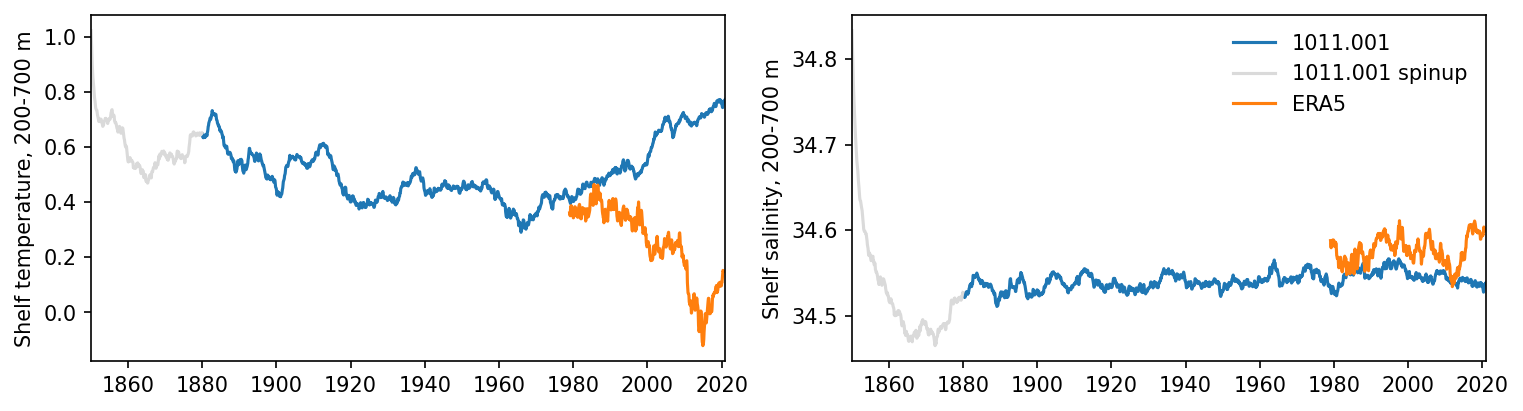

In [30]:
# create a new figure for each variable
fig, ax = plt.subplots(1,2, figsize=(12,3), dpi=150)

for v, var_name in enumerate(var_names):
    ax[v].plot(ens1011.isel(time_centered=slice(12*30,None))['time_counter'], ens1011.isel(time_centered=slice(12*30,None))[var_name], label='1011.001')
    ax[v].plot(ens1011.isel(time_centered=slice(0,12*30))['time_counter'], ens1011.isel(time_centered=slice(0,12*30))[var_name], label='1011.001 spinup', color='#dadada')
    ax[v].plot(era51['time_counter'], era51[var_name], label='ERA5')
    ax[v].set_ylabel(var_titles[v])
    
ax[1].legend(frameon=False)

for axis in ax.ravel():
    axis.set_xlim(ens1011.time_centered[0], ens1011.time_centered[-1])

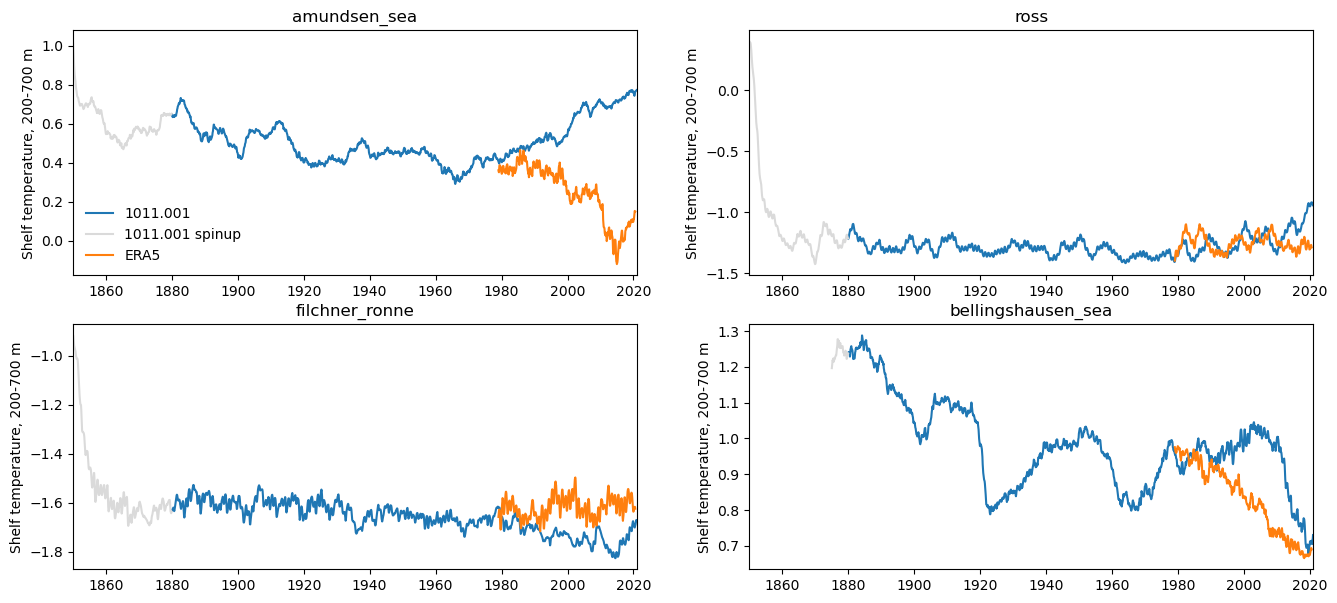

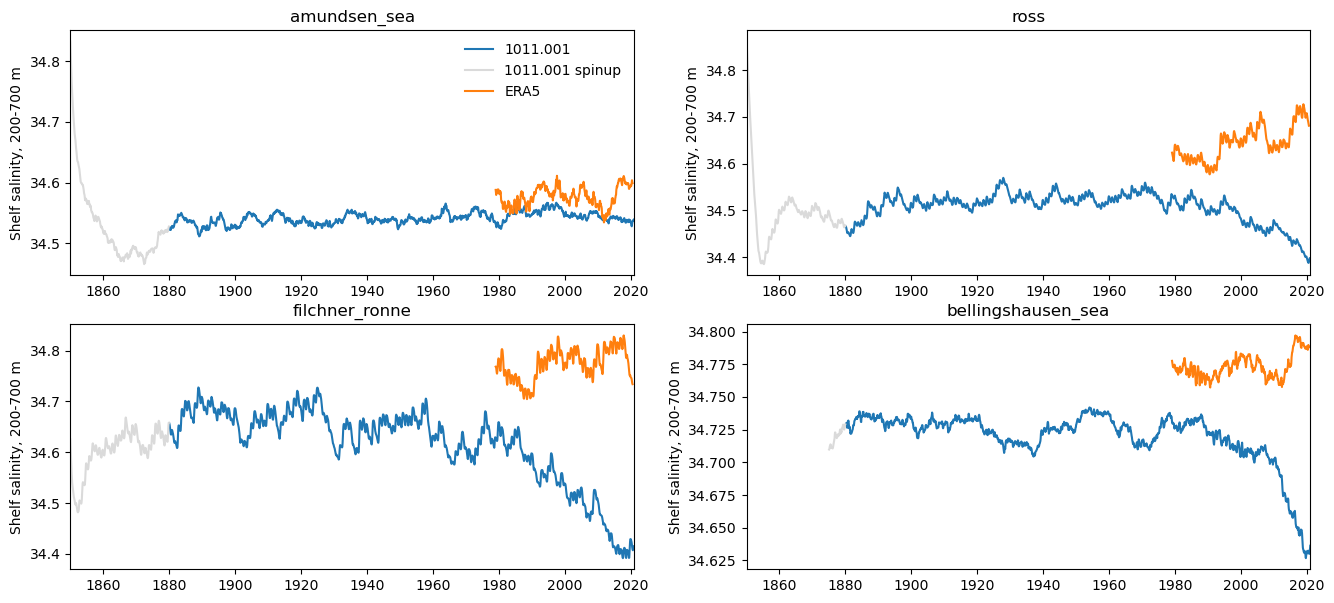

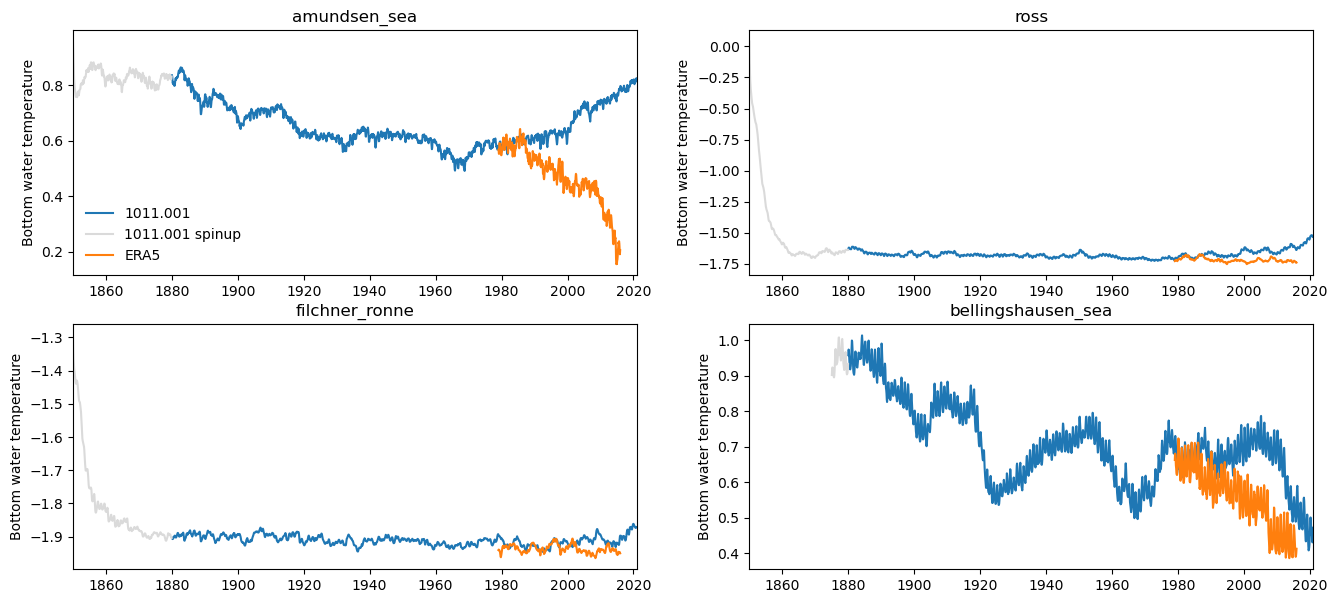

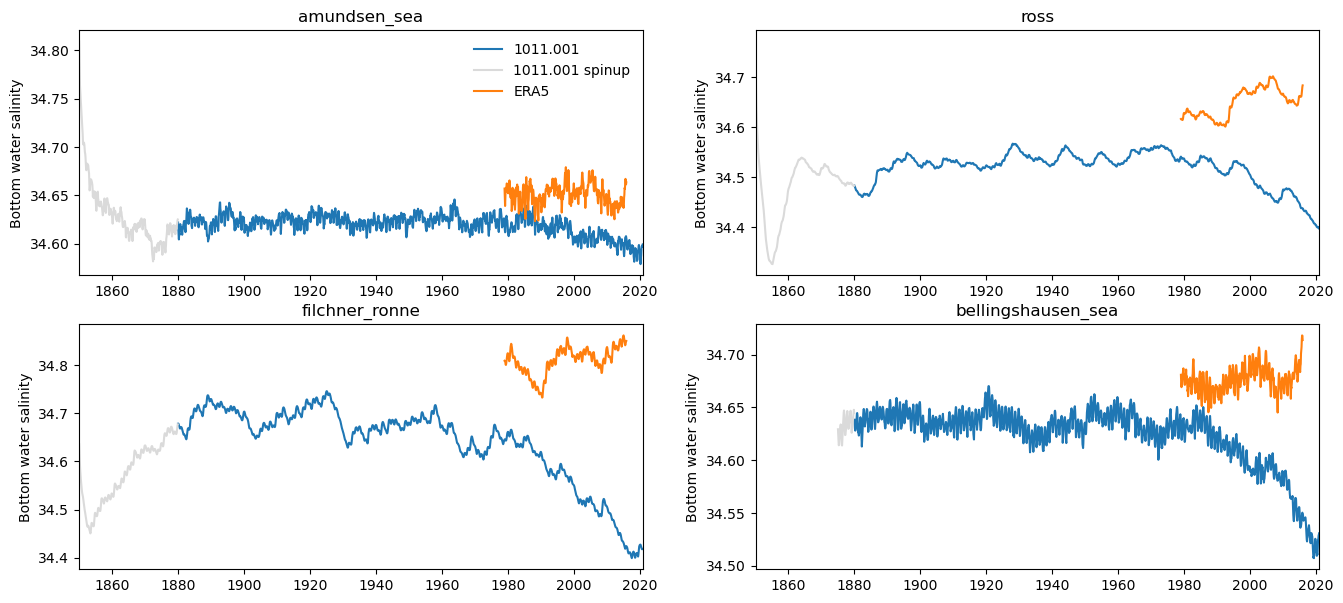

In [7]:
# create a new figure for each variable
for v, var_name in enumerate(var_names):
    
    fig, ax = setup_timeseries_axes(regions=regions)
    
    # ax = plot_timeseries(ax, var_name, ens1011, title=var_titles[v], regions=regions, runid='1011.001')
    ax = plot_timeseries(ax, var_name, ens1011.isel(time_centered=slice(12*30,None)), title=var_titles[v], regions=regions, runid='1011.001')
    ax = plot_timeseries(ax, var_name, ens1011.isel(time_centered=slice(0,12*30)), title=var_titles[v], regions=regions, color='#dadada', runid='1011.001 spinup')
    try:
        ax = plot_timeseries(ax, var_name, era5, title=var_titles[v], regions=regions, runid='ERA5')
    except:
        try:
            ax = plot_timeseries(ax, var_name, era51, title=var_titles[v], regions=regions, runid='ERA5')
        except:
            pass
    ax[0,0].legend(frameon=False)

    for axis in ax.ravel():
        axis.set_xlim(ens1011.time_centered[0], ens1011.time_centered[-1])

### Sea ice area

Overall and separated by region

In [5]:
ens1011_ice  = xr.open_mfdataset(f'{ens1011_dir}files/*ice*', chunks='auto')
pre1011_ice  = xr.open_mfdataset(f'{pre1011_dir}files_spinup/*ice*')
pre1011_ice2 = xr.open_mfdataset(f'{pre1011_dir}files/*ice*')
piC_ice      = xr.open_mfdataset(f'{piC_dir}files/*ice*')

In [10]:
present_day_time_shifted = xr.concat([pre1011_ice.time_counter - pd.Timedelta(days=365*129+31), 
                                      pre1011_ice2.time_counter - pd.Timedelta(days=365*92+53)], dim='time_counter')

present_day_ice_shifted = xr.concat([(pre1011_ice.siconc*pre1011_ice.area).sum(dim=['x','y'])*1e-6, 
                                    (pre1011_ice2.siconc*pre1011_ice2.area).sum(dim=['x','y'])*1e-6], dim='time_counter')

In [7]:
ice_vars = ['sithic', 'sisali', 'siapnd', 'sitemp', 'sidive', 'sishea', 'qt_oce_ai', 'qt_atm_oi', \
            'qtr_ice_bot', 'qt_ice', 'qemp_ice', 'sfxice', 'area']

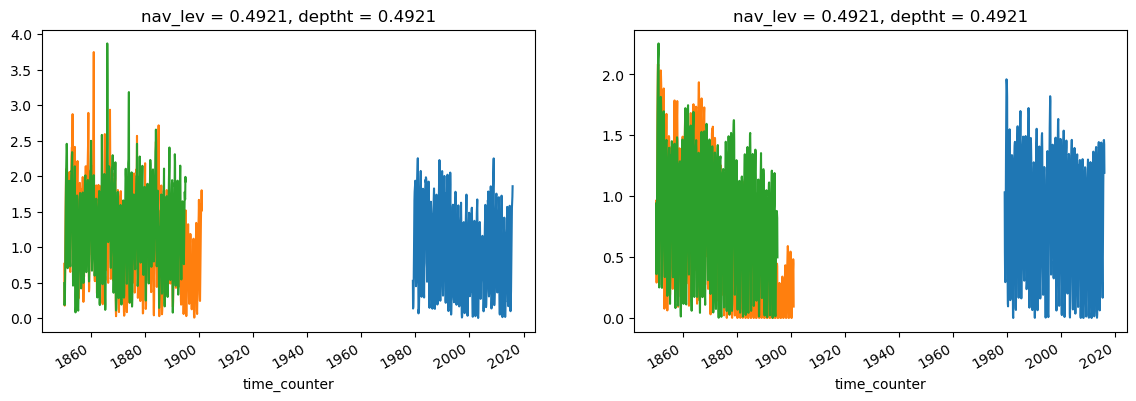

In [8]:
nemo_mesh_ds = xr.open_dataset('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/mesh_mask-20240305.nc').isel(time_counter=0, nav_lev=0)

var='sithic'

fig, ax = plt.subplots(1,2, figsize=(14,4), dpi=100)
for i, region in enumerate([weddell_convect, ross_convect]):
    for ds in [pre1011_ice, ens1011_ice, piC_ice]:
        nemo_ds    = ds.isel(x=region['x'], y=region['y']) 
        var_ocean  = xr.where(nemo_mesh_ds.isel(x=region['x'], y=region['y']).tmask==0, np.nan, nemo_ds[var])
        area_ocean = xr.where(nemo_mesh_ds.isel(x=region['x'], y=region['y']).tmask==0, np.nan, nemo_ds['area'])
        
        region_var = (var_ocean*area_ocean).sum(dim=['x','y'])/(area_ocean.sum(dim=['x','y']))
    
        region_var.plot(ax=ax[i])

Text(0, 0.5, 'Sea ice area (km2)')

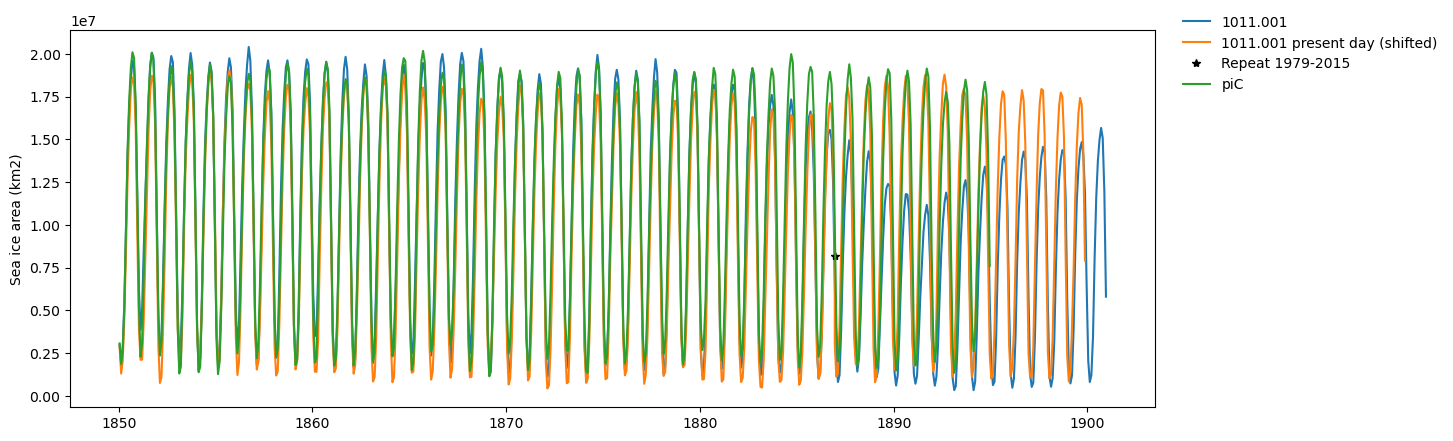

In [11]:
fig, ax = plt.subplots(1,1, figsize=(14,5), dpi=100)
ax.plot(ens1011_ice.time_counter, (ens1011_ice.siconc*ens1011_ice.area).sum(dim=['x','y'])*1e-6, label='1011.001')
ax.plot(present_day_time_shifted, present_day_ice_shifted, label='1011.001 present day (shifted)')
ax.plot(pre1011_ice.time_counter[-1] - pd.Timedelta(days=365*129+31), 
        ((pre1011_ice.siconc*pre1011_ice.area).sum(dim=['x','y'])*1e-6)[-1], '*k', label='Repeat 1979-2015')
ax.plot(piC_ice.time_counter , (piC_ice.siconc*piC_ice.area).sum(dim=['x','y'])*1e-6  , label='piC') 
ax.legend(frameon=False, loc=(1.02, 0.82))
ax.set_ylabel('Sea ice area (km2)')

Keep an eye out for whether the present day experiment starts convecting around the same time that the historical experiments starts convecting; in that case it would suggest it's likely a process that is gradually eroding the subsurface salinity rather than a process specific to the timing. What can be eroding the subsurface salinity? Could be from wind pattern differences. Or from 

Text(0, 0.5, 'Sea ice area (km2)')

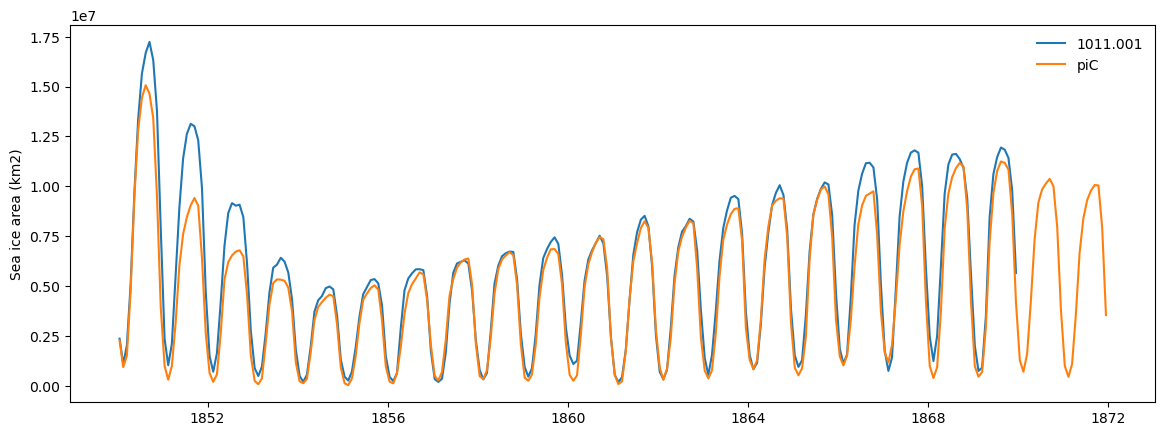

In [8]:
fig, ax = plt.subplots(1,1, figsize=(14,5), dpi=100)
ax.plot(ens1011_ice.time_counter, (ens1011_ice.siconc*ens1011_ice.area).sum(dim=['x','y'])*1e-6, label='1011.001')
ax.plot(piC_ice.time_counter, (piC_ice.siconc*piC_ice.area).sum(dim=['x','y'])*1e-6, label='piC') 
ax.legend(frameon=False)
ax.set_ylabel('Sea ice area (km2)')